In [3]:
### Importing dependencies to work with the data and create the model
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import  accuracy_score, classification_report
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd 
import psycopg2 
import pandas.io.sql as sqlio 
from sklearn.metrics import roc_curve, RocCurveDisplay, auc
import pickle
import boto3
import io




In [5]:
### Create connection with database and load database
connection = psycopg2.connect(user='postgres', password="Absdefg1", 
host='127.0.0.1',
port='5432', 
database='Startup-Analysis')
sql = "SELECT * FROM startup_alldata"
data = sqlio.read_sql_query(sql,connection)

In [6]:
### Check database head to see if the upload was done correct
data.head()

,state_code,year_,vp_gdp,labels,founded_at,age_first_funding_year,age_last_funding_year,age_first_milestone_year,age_last_milestone_year,relationships,...,has_angel,has_rounda,has_roundb,has_roundc,has_roundd,avg_participants,is_top500,reached_milestone,founded_first_funding_days_difference,first_last_funding_days_difference
0,CA,2007,1.9,1,2007,2.2493,3.0027,4.6685,6.7041,3,...,1,0,0,0,0,1.0000,0,1,821,275
1,CA,2000,7.7,1,2000,5.1260,9.9973,7.0055,7.0055,9,...,0,0,1,1,1,4.7500,1,1,1871,1778
2,CA,2009,3.2,1,2009,1.0329,1.0329,1.4575,2.2055,5,...,0,1,0,0,0,4.0000,1,1,377,0
3,CA,2002,1.8,1,2002,3.1315,5.3151,6.0027,6.0027,5,...,0,0,1,1,1,3.3333,1,1,1143,797
4,CA,2010,2.0,0,2010,0.0000,1.6685,0.0384,0.0384,2,...,1,0,0,0,0,1.0000,1,1,0,609


In [7]:
### 2 columns contain NA, this data is valuable so changing NA to value 999, the reason is the columns have values 0 by default, taking down the
## the columns we miss almost all 0 labels and the model wouldn´t couldn´t be trained
data["age_first_milestone_year"] = data["age_first_milestone_year"].fillna(value=999)
data["age_last_milestone_year"] = data["age_last_milestone_year"].fillna(value=999)

In [8]:
X = data.drop(["labels", "state_code", "founded_at", "year_"], axis= 1)
y = data["labels"]

For our X we have 35 columns:                  type: 







0   vp_gdp                                     float64

1   age_first_funding_year                     float64


2   age_last_funding_year                      float64 


3   age_first_milestone_year                   float64


4   age_last_milestone_year                    float64


5   relationships                              int64  
6   funding_rounds                             int64   
7   funding_total_usd                          int64  
8   milestones                                 int64  
9   is_ca                                      int64  
10  is_ny                                      int64  
11  is_ma                                      int64  
12  is_tx                                      int64  
13  is_otherstate                              int64  
14  is_software                                int64  
15  is_web                                     int64  
16  is_mobile                                  int64  
17  is_enterprise                              int64  
18  is_advertising                             int64  
19  is_gamesvideo                              int64  
20  is_ecommerce                               int64  
21  is_biotech                                 int64  
22  is_consulting                              int64  
23  is_othercategory                           int64  
24  has_vc                                     int64  
25  has_angel                                  int64  
26  has_rounda                                 int64   
27  has_roundb                                 int64  
28  has_roundc                                 int64  
29  has_roundd                                 int64  
30  avg_participants                           float64


31  is_top500                                  int64  
32  reached_milestone                          int64  
33  founded_first_funding_days_difference      int64  
34  first_last_funding_days_difference         int64 

For our prediction we have "labels", they go from 0 to 1, 0 being startups that failed and 1 succesfull, there are a total of 809 rows from 1985 to 2013, this dataset it´s from the US only trough out different states but with a concentration in California 

Using standard methodology to separate train and test data, after that we are going to scale with StandardScaler from sklearn.preprocessing so we don´t have outliers

In [9]:
data.shape

(908, 39)

In here we are creating a function for the model to be automatic and a model to show the scores and why we choose it 

In [25]:
### Create function for the model
def model_function(data):
    ### Selecting X and y
    X = data.drop(["labels", "state_code", "founded_at", "year_"], axis= 1)
    y = data["labels"]
    ### split the data into test and training
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    ### Scaling the sdata to avoid noise from outliers 
    ## Creating Scaler instance
    scaler = StandardScaler()
    ### fitting the data to the scaler
    X_scaler = scaler.fit(X_train)
    ## Transforming data
    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)
    ### Creating Classifier instance
    classifier = GradientBoostingClassifier(n_estimators=100,
   learning_rate=0.05,
   max_features=8,
   min_samples_leaf= 0.1,
   loss= 'deviance',
   max_depth=2,
   subsample = 0.95,
   random_state=0)
   ## Training the model
    classifier.fit(X_train_scaled, y_train)
    ###Predicting data
    y_pred = classifier.predict(X_test_scaled)
    y_proba = classifier.predict_proba(X_test_scaled)
    fpr, tpr, _ = roc_curve(y_test, y_proba[:,1])
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    plot = roc_display, plt.plot([0,1], [0,1], c="r")

    return classifier.score(X_test_scaled, y_test), plot


(0.8061674008810573,
 (<sklearn.metrics._plot.roc_curve.RocCurveDisplay at 0x20215649048>,
  [<matplotlib.lines.Line2D at 0x20215677948>]),
 array([0.8379339 , 0.90014076, 0.9110687 , 0.8758971 , 0.88378429,
        0.89517077, 0.0998962 , 0.33042499, 0.88457888, 0.91246738,
        0.83446582, 0.83693538, 0.75749457, 0.76592077, 0.88669597,
        0.85361309, 0.77603135, 0.63173809, 0.45977369, 0.86468975,
        0.3720076 , 0.91102084, 0.60464587, 0.90186086, 0.12460296,
        0.65790272, 0.74141288, 0.25603697, 0.59534184, 0.80854827,
        0.89197758, 0.91330724, 0.60239434, 0.84663295, 0.26607422,
        0.40686686, 0.62471231, 0.74147977, 0.49180662, 0.34287094,
        0.779504  , 0.85303663, 0.13177718, 0.36550874, 0.8945859 ,
        0.86388896, 0.90044213, 0.80767901, 0.74049057, 0.30891752,
        0.8558076 , 0.77325162, 0.85172834, 0.50586619, 0.83482606,
        0.68791659, 0.74173843, 0.80530594, 0.90075829, 0.72792545,
        0.54897793, 0.89783178, 0.89076543, 

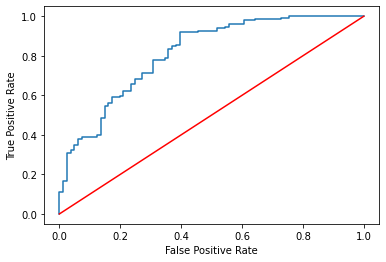

In [27]:
model_function(data)

In [33]:
### Split the data into test and train 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [34]:
### Going to scale the data to avoid outliers 
scaler = StandardScaler()
X_scaler = scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

Applying Gradient Boosting Classifier, Boosting has the idea of learning from each successful model ran and minimize the error. In a summarized way to see it the Gradient Boosting Classifier incorporates a minimize cost function to cast the next model

In [35]:
classifier = GradientBoostingClassifier(n_estimators=100,
   learning_rate=0.05,
   max_features=8,
   min_samples_leaf= 0.1,
   loss= 'deviance',
   max_depth=2,
   subsample = 0.95,
   random_state=0)


classifier.fit(X_train_scaled, y_train)
print("Accuracy score (training): {0:.2f}".format(
classifier.score(X_train_scaled, y_train)))
print("Accuracy score (validation): {0:.2f}".format(
classifier.score(X_test_scaled, y_test)))
y_pred = classifier.predict(X_test_scaled)





Accuracy score (training): 0.82
Accuracy score (validation): 0.81


In [37]:
pickle_out = open("model.pkl", "wb")
pickle.dump(classifier, pickle_out)
pickle_out.close()

In [36]:
print(log_loss(y_test, classifier.predict_proba(X_test_scaled)))

0.4872857595157492


AUC del set de prueba 0.7613732453915103


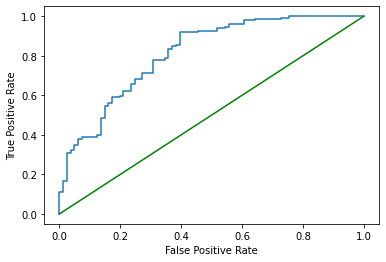

In [16]:
y_proba = classifier.predict_proba(X_test_scaled)
fpr, tpr, _ = roc_curve(y_test, y_proba[:,1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
plt.plot([0,1],[0,1], c='g')

fpr, tpr, thresholds = roc_curve(y_test,y_pred, pos_label=1)
print("AUC del set de prueba",  auc(fpr, tpr))

In [17]:
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.60      0.69        81
           1       0.81      0.92      0.86       146

    accuracy                           0.81       227
   macro avg       0.81      0.76      0.77       227
weighted avg       0.81      0.81      0.80       227

0.8061674008810573
[[ 49  32]
 [ 12 134]]


Creating this model we had a 80% acurracy, the model does what we need, with a 79% recall for 57% and 81% we have an almost certainty that we can detect the true successful or failed startups and with this we can forecast for new business